In [34]:
from statistics import kde

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [35]:
df = pd.read_csv("../data/Cancer_Data.csv")

## Vérification des valeurs manquantes

On visualise les valeurs manquantes avec une heatmap :
- une case claire indique une valeur présente
- une case sombre (ou vide selon le thème) indique une valeur manquante

Objectif : vérifier rapidement si un nettoyage des *NaN* est nécessaire.

<Axes: >

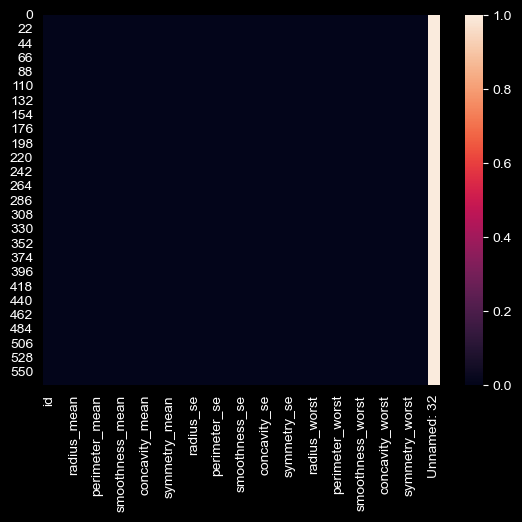

In [36]:
sns.heatmap(df.isnull())

## Sélection des variables utiles

On conserve uniquement :
- la variable cible **diagnosis** (B = bénin / M = malin)
- un ensemble de variables numériques (moyennes) décrivant les caractéristiques de la tumeur

Cela permet de travailler sur un sous-ensemble propre et pertinent du dataset.

## Vérification des types et structure

On utilise `info()` pour :
- vérifier le nombre d’observations et de colonnes
- vérifier les types (`int`, `float`, `object`)
- contrôler l’absence de valeurs manquantes dans les colonnes sélectionnées


In [37]:
colonnes = [
    "diagnosis",
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave points_mean",
    "symmetry_mean",
    "fractal_dimension_mean"
]

df_copy = df[colonnes].copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    object 
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), object(1)
memory usage: 49.0+ KB


## Encodage de la variable cible

La variable `diagnosis` est catégorielle (B/M).
On la transforme en variable binaire pour les modèles :

- **B (bénin) → 0**
- **M (malin) → 1**

Cela facilite l’utilisation d’algorithmes de classification.


In [38]:
df_copy['diagnosis'] = df_copy['diagnosis'].map({'B': 0, 'M': 1})
df_copy.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


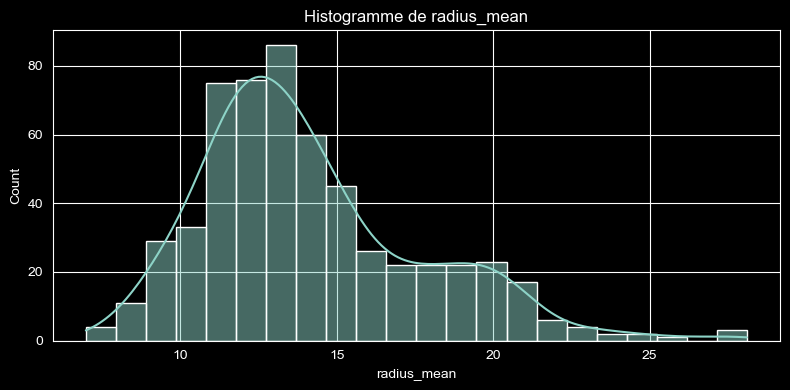

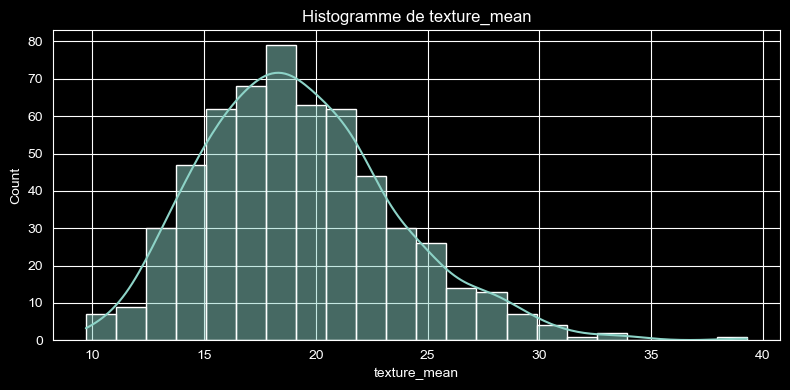

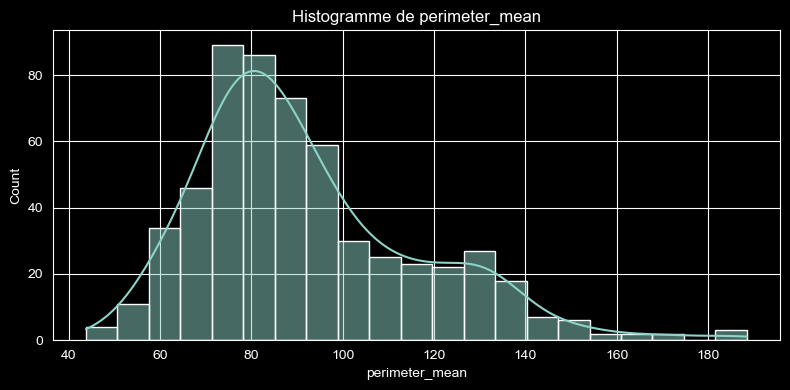

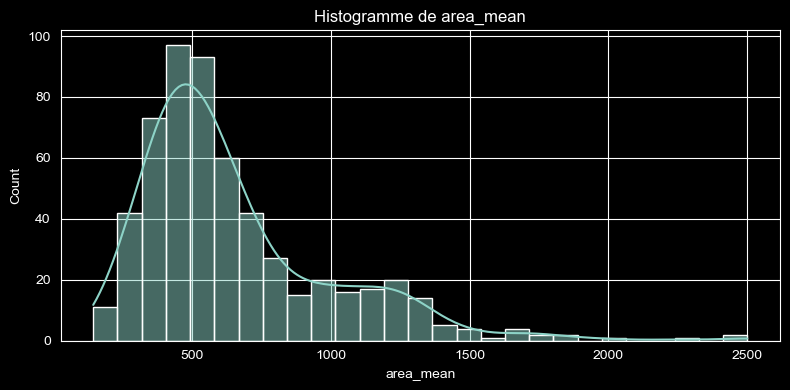

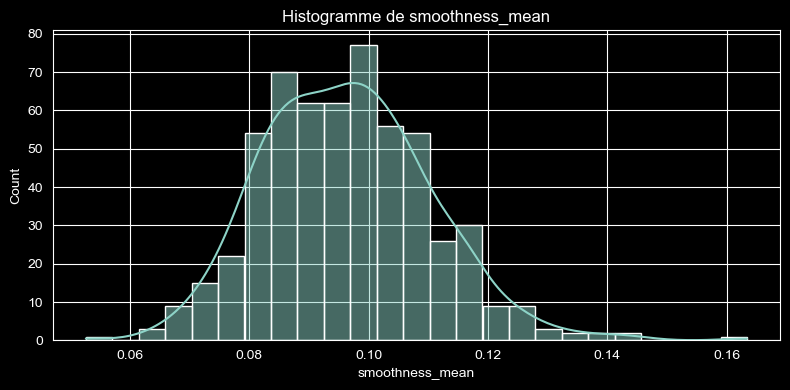

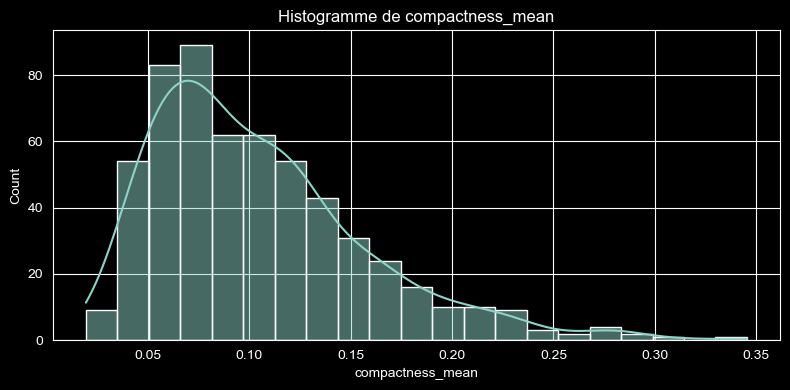

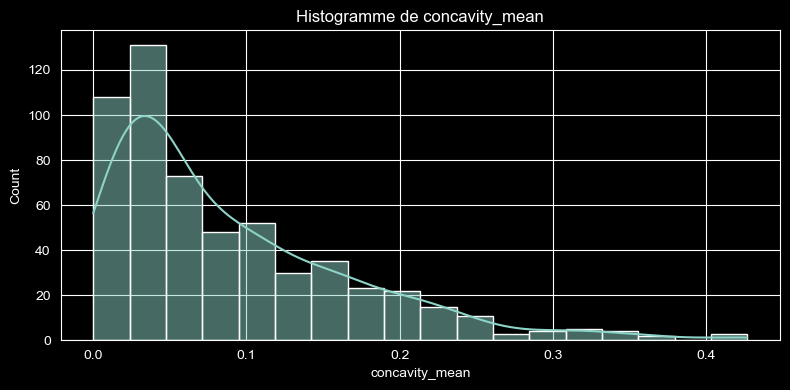

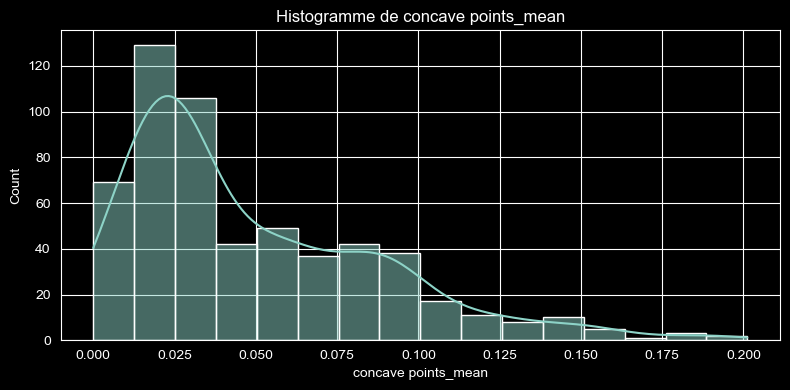

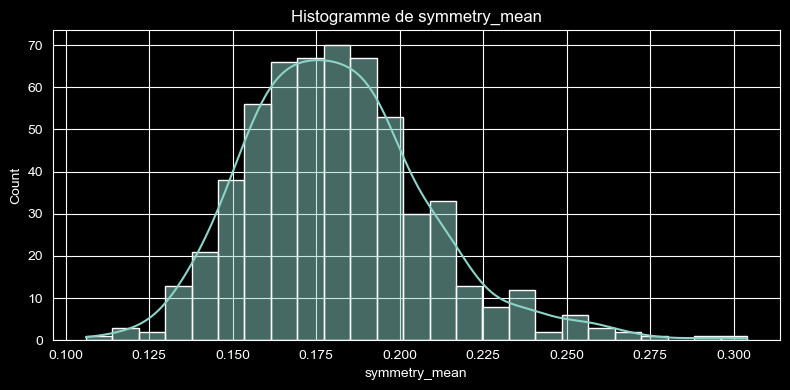

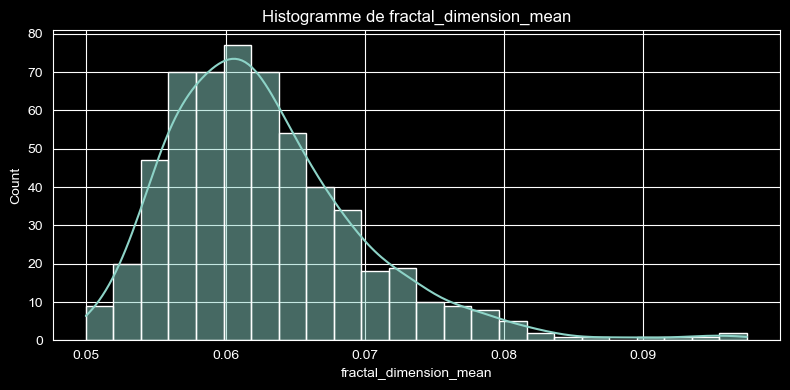

In [39]:
for col in df_copy.columns:
    if col != "diagnosis":
        plt.figure(figsize=(8, 4))
        sns.histplot(df_copy[col], kde=True)
        plt.title(f"Histogramme de {col}")
        plt.tight_layout()
        plt.show()

## Détection des outliers avec la méthode SD

Les valeurs aberrantes sont détectées à l’aide de la méthode basée sur l’écart-type (Standard Deviation).

Principe :
Pour chaque variable numérique, on calcule :

- une limite inférieure :
  moyenne − 3 × écart-type

- une limite supérieure :
  moyenne + 3 × écart-type

Toute observation située en dehors de cet intervalle est considérée comme potentiellement aberrante.

Ce seuil de ±3 écarts-types repose sur la règle empirique : dans une distribution approximativement normale, 99,7 % des observations se situent dans cet intervalle. Les valeurs au-delà peuvent donc être considérées comme extrêmes.

Cette méthode permet d’identifier les observations très éloignées de la moyenne, tout en restant simple et interprétable.

Les lignes contenant au moins une valeur hors de ces bornes sont temporairement retirées afin d’analyser l’impact du nettoyage sur la structure du dataset.

In [40]:
def sd_outliers(df_col : pd.Series) -> tuple:
    seuil = 3 # on peut aussi mettre le seuil en argument de la fonction
    limite_sup = df_col.mean() + seuil * df_col.std()
    limite_inf = df_col.mean() - seuil * df_col.std()

    return (limite_inf, limite_sup)

In [41]:
df_clean = df_copy.copy()

for col in df_clean.columns:
    if col != "diagnosis":
        inf, sup = sd_outliers(df_clean[col])
        df_clean = df_clean[
            (df_clean[col] >= inf) &
            (df_clean[col] <= sup)
        ]

print("Dataset copie :", df_copy.shape)
print("Dataset nettoyé :", df_clean.shape)
print("Nb de donnée abérrantes :", df_copy.shape[0] - df_clean.shape[0])

Dataset copie : (569, 11)
Dataset nettoyé : (523, 11)
Nb de donnée abérrantes : 46


In [42]:
df_copy['diagnosis'].value_counts(normalize=True)

diagnosis
0    0.627417
1    0.372583
Name: proportion, dtype: float64

In [43]:
df_clean['diagnosis'].value_counts(normalize=True)

diagnosis
0    0.657744
1    0.342256
Name: proportion, dtype: float64

## Décision concernant les valeurs aberrantes (outliers)

L’application de la méthode ±3 écarts-types a conduit à la suppression de 46 observations, soit environ 8 % du dataset initial (569 → 523 observations).

L’analyse de la distribution des classes avant et après nettoyage montre une modification de l’équilibre :

- Dataset initial : 37,3 % de cas malins
- Dataset nettoyé : 34,2 % de cas malins

On observe donc une diminution relative des cas malins après suppression des valeurs extrêmes.

Dans un contexte de classification médicale, ces observations extrêmes correspondent majoritairement à des tumeurs présentant des caractéristiques sévères mais biologiquement plausibles (grande taille, forte concavité, etc.). Elles contiennent donc une information discriminante importante.

La suppression automatique de ces observations pourrait introduire un biais et réduire la capacité du modèle à détecter les cas les plus graves.

Par conséquent, malgré leur caractère statistiquement extrême, l’ensemble des 569 observations est conservé pour la modélisation finale.

## Export du dataset

On enregistre le dataset préparé en CSV pour l’utiliser ensuite dans les étapes de modélisation.


In [44]:
file_path = "../data/data_cleaning.csv"

if not os.path.exists(file_path):
    df_copy.to_csv(file_path, index=False)
    print("Fichier créé.")
else:
    print("Le fichier existe déjà. Aucune écriture effectuée.")

Le fichier existe déjà. Aucune écriture effectuée.
